In [1]:
! nvidia-smi

Sat Aug 15 02:09:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## LSTM

### 讀取資料

In [4]:
import pandas_datareader
dataset = pandas_datareader.get_data_yahoo('2330.TW', start = '2000-01-01')

In [5]:
dataset.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-04,69.649002,68.475197,69.649002,69.649002,2.006623e+11,37.032295
2000-01-05,71.214104,68.866302,69.649002,71.214104,4.024668e+11,37.864456
2000-01-06,71.214104,69.649002,70.822899,69.649002,1.975457e+11,37.032295
2000-01-07,68.475197,66.518600,67.301300,67.692497,2.352703e+11,35.992020
2000-01-10,70.431396,68.475197,69.649002,70.040199,2.761717e+11,37.240295


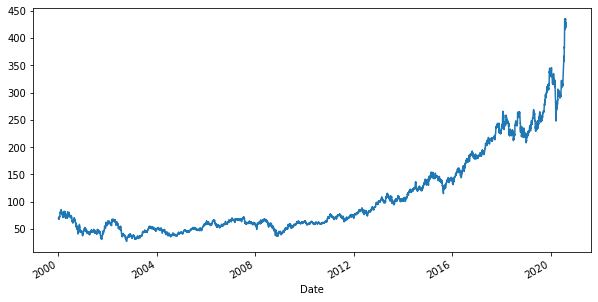

In [7]:
dataset['Close'].plot(kind = 'line', figsize = [10,5])

In [9]:
dataset = dataset[['Close']].values 

### 資料標準化

In [12]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled  = sc.fit_transform(dataset)

In [13]:
training_set_scaled

array([[0.10339779],
       [0.10723344],
       [0.10339779],
       ...,
       [0.95956295],
       [0.98407025],
       [0.97916879]])

In [14]:
len(training_set_scaled)

5079

In [17]:
import numpy as np
X_train = []
y_train = []
for i in range(60,len(training_set_scaled)):
  X_train.append(training_set_scaled[i-60:i,0])
  y_train.append(training_set_scaled[i,0])

In [18]:
X_train, y_train = np.array(X_train), np.array(y_train)

In [19]:
X_train.shape

(5019, 60)

In [21]:
X_train[0]

array([0.10339779, 0.10723344, 0.10339779, 0.09860293, 0.10435651,
       0.10147961, 0.1062747 , 0.10339779, 0.10723344, 0.11202828,
       0.10915136, 0.10915136, 0.10723344, 0.11106882, 0.112987  ,
       0.11778187, 0.1302475 , 0.13216568, 0.1283303 , 0.12737083,
       0.12641212, 0.12641212, 0.12641212, 0.12641212, 0.12641212,
       0.12641212, 0.13504261, 0.13791927, 0.14271438, 0.13791927,
       0.138878  , 0.13696079, 0.13504261, 0.13216568, 0.11969906,
       0.11969906, 0.11874034, 0.11969906, 0.12353544, 0.12353544,
       0.12545265, 0.1302475 , 0.12737083, 0.12737083, 0.12449393,
       0.12353544, 0.12257574, 0.12449393, 0.11969906, 0.10723344,
       0.11106882, 0.10819191, 0.10915136, 0.11490495, 0.10915136,
       0.11969906, 0.11682216, 0.12545265, 0.12257574, 0.13504261])

In [22]:
y_train.shape

(5019,)

In [23]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [24]:
X_train.shape

(5019, 60, 1)

(5019, 60, 1)

- 5019: 資料筆數
- 60: 時間的 sliding window
- 1: 特徵數量

### 建立模型

In [25]:
% tensorflow_version 2.x

In [26]:
import tensorflow as tf

In [27]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM, Dropout


In [28]:
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True)) 
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True)) 
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

In [30]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [ ]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

### 驗證模型

In [32]:
pred_y = regressor.predict(X_train)

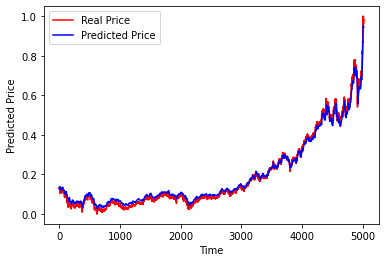

In [35]:

from matplotlib import pyplot as plt
plt.plot(y_train, color = 'red', label = 'Real Price')
plt.plot(pred_y, color = 'blue', label = 'Predicted Price')
plt.xlabel('Time')
plt.ylabel('Predicted Price')
plt.legend()
plt.show()

## 將資料分為訓練與測試資料集

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [36]:
len(training_set_scaled)

5079

In [42]:
import numpy as np
X_train = []
y_train = []
for i in range(60,4000):
  X_train.append(training_set_scaled[i-60:i,0])
  y_train.append(training_set_scaled[i,0])


X_test = []
y_test = []

for i in range(4000 - 60,len(training_set_scaled)):
  X_test.append(training_set_scaled[i-60:i,0])
  y_test.append(training_set_scaled[i,0])

In [43]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

In [44]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [46]:
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True)) 
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True)) 
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

In [ ]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train, y_train, epochs = 20, batch_size = 32)

In [48]:
pred_y = regressor.predict(X_test)

In [51]:
pred_y.shape

(1139, 1)

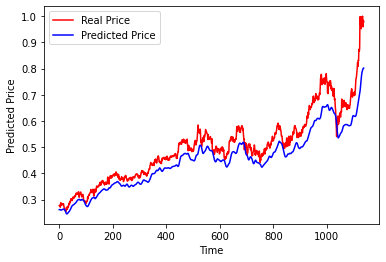

In [49]:

from matplotlib import pyplot as plt
plt.plot(y_test, color = 'red', label = 'Real Price')
plt.plot(pred_y, color = 'blue', label = 'Predicted Price')
plt.xlabel('Time')
plt.ylabel('Predicted Price')
plt.legend()
plt.show()

In [55]:
y_real_test = sc.inverse_transform(y_test.reshape(-1,1)).flatten()

In [56]:
y_real_pred = sc.inverse_transform(pred_y.reshape(-1,1)).flatten()

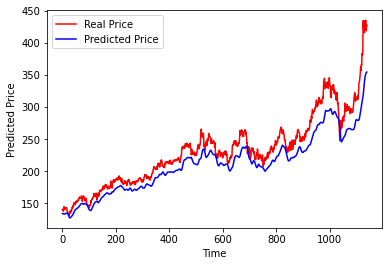

In [57]:

from matplotlib import pyplot as plt
plt.plot(y_real_test, color = 'red', label = 'Real Price')
plt.plot(y_real_pred, color = 'blue', label = 'Predicted Price')
plt.xlabel('Time')
plt.ylabel('Predicted Price')
plt.legend()
plt.show()

## 驗證碼辨識案例
- https://drive.google.com/file/d/1vEbLS19iIHNXAIyfmLblSCe5jpRTLgF3/view?usp=sharing

In [1]:
! gdown https://drive.google.com/u/1/uc?id=1vEbLS19iIHNXAIyfmLblSCe5jpRTLgF3&export=download

Downloading...
From: https://drive.google.com/u/1/uc?id=1vEbLS19iIHNXAIyfmLblSCe5jpRTLgF3
To: /content/shwoo_image.zip
5.36MB [00:00, 85.0MB/s]


In [5]:
! nvidia-smi

Sat Aug 15 03:31:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
! ls /content/drive/My\ Drive/aidataset/

aoi.zip		   data_edited_2018.csv       shwoo_image.zip  yolov4.weights
cfg_mask	   medical-masks-dataset.zip  test.jpg
darknet53.conv.74  new_best_model.h5	      weights


In [59]:
! cp /content/drive/My\ Drive/aidataset/darknet53.conv.74 ./

In [2]:
! cp /content/drive/My\ Drive/aidataset/shwoo_image.zip ./

In [3]:
! unzip shwoo_image.zip > zip.log

In [14]:
from PIL import Image
img = Image.open('images/118rxy.jpg')
img

In [15]:
import numpy as np
im = np.array(img)
im.shape

(27, 85, 3)

In [16]:
import os
captcha_ary = []
for f in os.listdir('images/'):
  captcha_ary.append({'captcua':f.strip('.jpg'), 'fname':'images/' + f})


In [17]:
import pandas
captcha = pandas.DataFrame(captcha_ary)

In [18]:
captcha.head()

,captcua,fname
0,xldge,images/jxldge.jpg
1,8qbuzy,images/8qbuzy.jpg
2,6gf8tq,images/6gf8tq.jpg
3,osbcnb,images/osbcnb.jpg
4,ronhxf,images/ronhxf.jpg


In [19]:
characters = '0123456789abcdefghijklmnopqrstuvwxyz'
height, width = 27,85
n_len = 6
n_class = len(characters)
print(height, width, n_class,n_len)

27 85 36 6


In [20]:
X = np.zeros((len(captcha), height, width, 3), dtype=np.float32)
y = [np.zeros((len(captcha), n_class), dtype=np.uint8) for i in range(n_len)]

In [21]:
for i in range(len(captcha)):
    random_str = captcha.iloc[i,0]
    fname = captcha.iloc[i,1]
    img = Image.open(fname)
    img = img.resize((width, height))
    im = np.array(img)
    X[i] = im * 1.0 / 255.0
    for j, ch in enumerate(random_str):
        y[j][i, :] = 0
        y[j][i, characters.find(ch)] = 1

In [22]:
y[0][0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], dtype=uint8)

In [23]:
#X[0][0]

In [24]:
import random
def gen(batch_size=32):
    X = np.zeros((batch_size, height, width, 3), dtype=np.float32)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
    while True:
        for i in range(batch_size):
            rand_index = random.choice(range(len(captcha)))
            random_str = captcha.iloc[rand_index,0]
            fname = captcha.iloc[rand_index,1]
            img = Image.open(fname)
            img = img.resize((width, height))
            im = np.array(img)
            X[i] = im / 255.0

            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, characters.find(ch)] = 1
        yield X, y

In [25]:
%tensorflow_version 2.x
import tensorflow as tf

In [26]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dropout, Input, Dense

In [27]:
input_tensor = Input((height, width, 3))

x = input_tensor



x = Conv2D(64, (3, 3), activation='relu')(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu')(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x) 



x = Flatten()(x)
x = Dropout(0.25)(x)

In [28]:
x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(6)]

model = Model(inputs=input_tensor, outputs=x)

In [29]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [40]:
! ls /content/drive/My\ Drive/aidataset/

aoi.zip			   model.03-1.29.h5  model.10-1.94.h5
cfg_mask		   model.04-1.41.h5  new_best_model.h5
darknet53.conv.74	   model.05-1.01.h5  shwoo_image.zip
data_edited_2018.csv	   model.06-2.47.h5  test.jpg
medical-masks-dataset.zip  model.07-2.24.h5  weights
model.01-1.86.h5	   model.08-1.70.h5  yolov4.weights
model.02-1.98.h5	   model.09-2.79.h5


In [39]:
my_callbacks = [
    #tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/My Drive/aidataset/model.{epoch:02d}-{val_loss:.2f}.h5'),
    #tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]
history = model.fit_generator(gen(batch_size=32),      # 每次生成器會產生32筆小批量的資料
                 epochs=10,                # 總共跑5個訓練循環
                 steps_per_epoch=100,
                 callbacks=my_callbacks,          # 保存最好的模型到檔案
                 validation_data=gen(batch_size=32),   # 驗證資料也是用生成器來產生
                 validation_steps=10      # 用40組資料來驗證
                   )

Epoch 1/10
100/100 [==============================] - 2s 21ms/step - loss: 1.8642 - c1_loss: 0.1334 - c2_loss: 0.1398 - c3_loss: 0.2010 - c4_loss: 0.1616 - c5_loss: 0.3269 - c6_loss: 0.9015 - c1_accuracy: 0.9878 - c2_accuracy: 0.9878 - c3_accuracy: 0.9828 - c4_accuracy: 0.9847 - c5_accuracy: 0.9534 - c6_accuracy: 0.7975 - val_loss: 1.8575 - val_c1_loss: 0.2944 - val_c2_loss: 0.1968 - val_c3_loss: 0.0902 - val_c4_loss: 0.1771 - val_c5_loss: 0.2174 - val_c6_loss: 0.8816 - val_c1_accuracy: 0.9719 - val_c2_accuracy: 0.9812 - val_c3_accuracy: 0.9937 - val_c4_accuracy: 0.9781 - val_c5_accuracy: 0.9594 - val_c6_accuracy: 0.8000
Epoch 2/10
100/100 [==============================] - 2s 20ms/step - loss: 2.0651 - c1_loss: 0.2132 - c2_loss: 0.1711 - c3_loss: 0.2751 - c4_loss: 0.1996 - c5_loss: 0.3234 - c6_loss: 0.8828 - c1_accuracy: 0.9794 - c2_accuracy: 0.9834 - c3_accuracy: 0.9725 - c4_accuracy: 0.9800 - c5_accuracy: 0.9525 - c6_accuracy: 0.8075 - val_loss: 1.9789 - val_c1_loss: 0.1847 - val_c2

## 多變數時間序列

### 讀取資料

In [41]:
from pandas import read_csv
from datetime import datetime

def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')

dataset = read_csv('https://raw.githubusercontent.com/ywchiu/tibamedl/master/Data/pollution.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.head()

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0


### 資料預處理

In [42]:
dataset.drop('No', axis=1, inplace=True)
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
dataset['pollution'].fillna(0, inplace=True)

In [43]:
dataset.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-01 00:00:00,0.0,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,0.0,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,0.0,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,0.0,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,0.0,-20,-12.0,1018.0,NW,12.97,0,0


In [44]:
dataset = dataset[24:]

In [45]:
dataset.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


## 探索資料

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['datetime', 'f', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


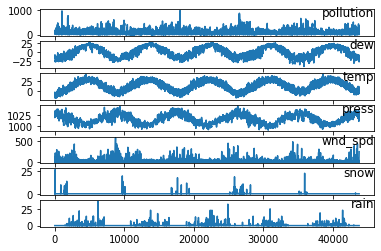

In [46]:
%pylab inline
from matplotlib import pyplot
values = dataset.values

groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

### 資料編碼

In [47]:
dataset.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [48]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
dataset['wnd_dir']= encoder.fit_transform(dataset['wnd_dir'])
dataset.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,2,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,2,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,2,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,2,6.25,2,0


### 資料正規化

In [51]:
values = dataset.values

In [52]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

### 資料轉換

In [53]:

import pandas
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pandas.DataFrame(data)
	cols, names = list(), list()
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pandas.concat(cols, axis=1)
	agg.columns = names
    
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [54]:
reframed = series_to_supervised(scaled, 1, 1)

In [55]:
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,0.229508,0.545455,0.666667,0.005332,0.000000,0.0
3,0.159960,0.426471,0.229508,0.545455,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,0.229508,0.563636,0.666667,0.008391,0.037037,0.0
4,0.182093,0.485294,0.229508,0.563636,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,0.229508,0.563636,0.666667,0.009912,0.074074,0.0
5,0.138833,0.485294,0.229508,0.563636,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,0.213115,0.563636,0.666667,0.011433,0.111111,0.0


In [56]:
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545455,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563636,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563636,0.666667,0.009912,0.074074,0.0,0.109658


### 分為訓練與測試資料集

In [57]:
values = reframed.values
n_train_hours = 365 * 24

train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]


In [58]:
train_X.shape

(8760, 8)

In [60]:
train_y.shape

(8760,)

In [61]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((8760, 1, 8), (8760,), (35039, 1, 8), (35039,))

(8760, 1, 8)

- 8760: 資料筆數
- 1: 時間window
- 8: 特徵的數量

### 建立模型

In [64]:
% %tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(50, return_sequences = True))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

### 訓練模型

In [ ]:
history = model.fit(train_X, train_y, 
          epochs=50, 
          batch_size=72, 
          validation_data=(test_X, test_y), 
          verbose=1, 
          shuffle=False)

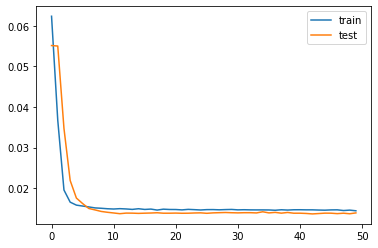

In [66]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### 驗證結果

In [67]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [71]:
yhat.shape

(35039, 1, 1)

In [75]:
yhat = yhat.flatten()

In [76]:
test_y.shape

(35039,)

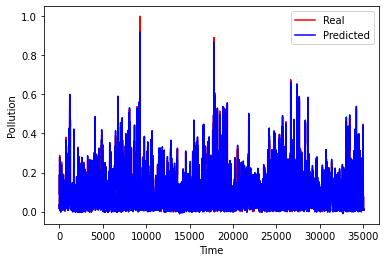

In [77]:

from matplotlib import pyplot as plt
plt.plot(test_y, color = 'red', label = 'Real')
plt.plot(yhat, color = 'blue', label = 'Predicted')
plt.xlabel('Time')
plt.ylabel('Pollution')
plt.legend()
plt.show()

## 計算RMSE

In [78]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test_y, yhat)

0.0007390017713704497

## Seq2Seq

In [2]:
from pandas import read_csv
from datetime import datetime

def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')

dataset = read_csv('https://raw.githubusercontent.com/ywchiu/tibamedl/master/Data/pollution.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.head()

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [3]:
dataset.drop('No', axis=1, inplace=True)
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
dataset['pollution'].fillna(0, inplace=True)
dataset = dataset[24:]
dataset.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [4]:
from sklearn.preprocessing import LabelEncoder
values = dataset.values
encoder = LabelEncoder()
wnd_dir = encoder.fit_transform(values[:,4])

In [5]:
dataset['wnd_dir'] = wnd_dir

In [6]:
dataset.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,2,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,2,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,2,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,2,6.25,2,0


In [7]:
from sklearn.preprocessing import StandardScaler

def df_to_lstm_format(df, test_size=0.5, look_back=5, target_column='target', scale_X=True):

    df = df.copy()

    # 最後一個欄位為預測目標
    df['target'] = df[target_column] 
    # 捨棄 y
    df = df.drop(columns=[target_column]) 
    
    # 取得目標 y
    target_location = df.shape[1] - 1 
    
    # 根據 test_size 比例分割資料
    split_index = int(df.shape[0]*test_size) 
    
    # 訓練資料集
    X_train = df.values[:split_index, :target_location]
    y_train = df.values[:split_index, target_location]

    # 測試資料集
    X_test = df.values[split_index:, :target_location] 
    y_test = df.values[split_index:, target_location] 

    # 將資料正規化 (如果 scale_X 為True)
    if scale_X:
        scalerX = StandardScaler(with_mean=True, with_std=True).fit(X_train)
        X_train = scalerX.transform(X_train)
        X_test = scalerX.transform(X_test)
        
    # 重塑輸入矩陣
    samples = len(X_train) 
    num_features = target_location 

    samples_train = X_train.shape[0] - look_back
    
    # 重塑訓練資料
    # (資料筆數, 往前看多少筆, 特徵數量)
    X_train_reshaped = np.zeros((samples_train, look_back, num_features))
    y_train_reshaped = np.zeros((samples_train))

    
    for i in range(samples_train):
        y_position = i + look_back
        X_train_reshaped[i] = X_train[i:y_position]
        y_train_reshaped[i] = y_train[y_position]

    # 重塑測試資料
    samples_test = X_test.shape[0] - look_back
    X_test_reshaped = np.zeros((samples_test, look_back, num_features))
    y_test_reshaped = np.zeros((samples_test))

    for i in range(samples_test):
        y_position = i + look_back
        X_test_reshaped[i] = X_test[i:y_position]
        y_test_reshaped[i] = y_test[y_position]
    
    return X_train_reshaped, y_train_reshaped, X_test_reshaped, y_test_reshaped

In [9]:
import numpy as np
look_back = 24
test_size = 0.5


X_train, y_train, X_test, y_test = df_to_lstm_format(df=dataset, 
                             test_size=test_size, 
                             look_back=look_back, 
                             target_column='pollution', scale_X=True)

In [10]:
X_train.shape

(21876, 24, 7)

### 建立 Seq2Seq 模型 (LSTM)

#### 編碼器 (Encoder)

In [14]:
% tensorflow_version 2.x
import tensorflow as tf

In [15]:
num_features = dataset.shape[1] - 1
num_features

7

In [16]:
encoder_inputs = tf.keras.layers.Input(shape=(None, num_features))
encoder = tf.keras.layers.LSTM(50, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

#### 解碼器 (Decoder)

In [17]:
decoder_inputs = tf.keras.layers.Input(shape=(None, 1))
decoder_lstm = tf.keras.layers.LSTM(50, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                    initial_state=2
decoder_dense = tf.keras.layers.Dense(1, activation='linear')
decoder_outputs = decoder_dense(decoder_outputs)

## 建立且編譯模型

In [18]:
import tensorflow.keras.backend as K
def mape(y_true, y_pred):
    return (K.abs(y_true - y_pred) / K.abs(y_pred)) * 100

def smape(y_true, y_pred):
    return (K.abs(y_pred - y_true) / ((K.abs(y_true) + K.abs(y_pred))))*100

In [19]:
model = tf.keras.models.Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='mse', metrics=[mape, smape])

In [20]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 7)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50), (None,  11600       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 50), ( 10400       input_2[0][0]                    
                                                                 lstm[0][1]            

In [21]:
# 建立編碼器與解碼器所需numpy array
encoder_input_train = X_train
decoder_input_train = np.zeros((X_train.shape[0], X_train.shape[1], 1)) # Zeros array
decoder_output_train = y_train.reshape((y_train.shape[0], 1, 1))

encoder_input_test = X_test
decoder_input_test = np.zeros((X_test.shape[0], X_test.shape[1], 1)) # Zeros array
decoder_output_test = y_test.reshape((y_test.shape[0], 1, 1))

In [22]:
encoder_input_train.shape

(21876, 24, 7)

In [23]:
decoder_input_train.shape

(21876, 24, 1)

In [24]:
decoder_output_train.shape

(21876, 1, 1)

## 訓練模型

In [26]:
model.fit([encoder_input_train, decoder_input_train], decoder_output_train, 
          validation_data=([encoder_input_test, decoder_input_test], decoder_output_test), 
          epochs=10, verbose=1)

Epoch 1/10
684/684 [==============================] - 7s 10ms/step - loss: 3903.8496 - mape: 48.3796 - smape: 26.1239 - val_loss: 4683.9351 - val_mape: 54.4260 - val_smape: 26.0725
Epoch 2/10
684/684 [==============================] - 7s 10ms/step - loss: 3714.7610 - mape: 47.7448 - smape: 25.8112 - val_loss: 4859.0459 - val_mape: 58.3362 - val_smape: 26.7377
Epoch 3/10
684/684 [==============================] - 7s 10ms/step - loss: 3515.5779 - mape: 48.5420 - smape: 25.4973 - val_loss: 5138.0894 - val_mape: 54.1736 - val_smape: 27.2840
Epoch 4/10
684/684 [==============================] - 7s 10ms/step - loss: 3355.2771 - mape: 46.3142 - smape: 25.1684 - val_loss: 5505.0337 - val_mape: 56.1383 - val_smape: 28.4938
Epoch 5/10
684/684 [==============================] - 7s 10ms/step - loss: 3276.1462 - mape: 46.6839 - smape: 25.1381 - val_loss: 5143.5010 - val_mape: 56.3638 - val_smape: 27.4902
Epoch 6/10
684/684 [==============================] - 7s 10ms/step - loss: 3140.4680 - mape: 45

## 產生預測結果

In [27]:

encoder_model = tf.keras.models.Model(encoder_inputs, encoder_states)

decoder_state_input_h = tf.keras.layers.Input(shape=(50,))
decoder_state_input_c = tf.keras.layers.Input(shape=(50,))

decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)

decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = tf.keras.models.Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [28]:
def predict(x, encoder_predict_model, decoder_predict_model, num_steps_to_predict):
    y_predicted = []

    # 將輸入值轉變為狀態向量
    states = encoder_predict_model.predict(x)

    # 狀態向量必須是 list
    if not isinstance(states, list):
        states = [states]

    # 產生第一筆解碼值
    decoder_input = np.zeros((x.shape[0], 1, 1))


    for _ in range(num_steps_to_predict):
        outputs_and_states = decoder_predict_model.predict(
        [decoder_input] + states, batch_size=batch_size)
        output = outputs_and_states[0]
        states = outputs_and_states[1:]

        # 增加預測結果
        y_predicted.append(output)

    return np.concatenate(y_predicted, axis=1)

In [29]:
num_steps_to_predict = 1
batch_size = 1

y_preds= predict(X_test, encoder_model, decoder_model, num_steps_to_predict)
y_preds = y_preds.reshape(y_preds.shape[0])
y_preds.shape

(21876,)

In [30]:
y_preds

array([33.80191 , 30.67473 , 25.979864, ..., 11.590134, 11.329283,
       11.107168], dtype=float32)

In [31]:
y_true = y_test.reshape(y_test.shape[0])

In [32]:
split_index = int(dataset.shape[0]*test_size)
x = dataset[split_index:]

In [33]:
datetime_difference = len(x) - len(y_true)
x = x[datetime_difference:] # 修正延遲數
x.index.shape

(21876,)

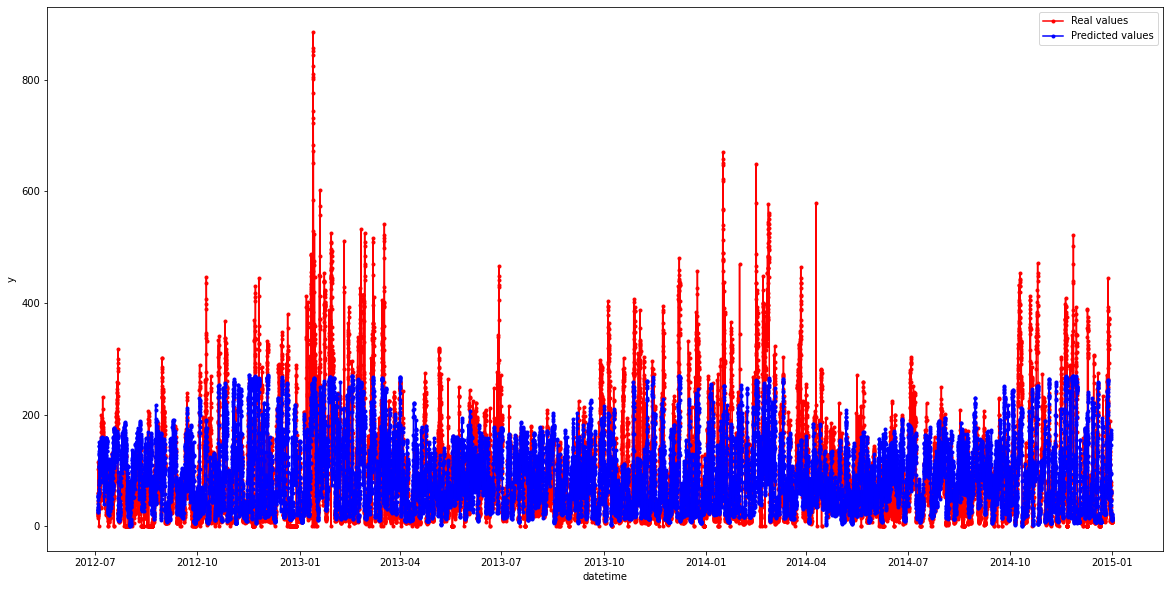

In [34]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(x.index, y_true, '.-', color='red', label='Real values')
plt.plot(x.index, y_preds, '.-', color='blue', label='Predicted values')

plt.ylabel('y')
plt.xlabel('datetime')
plt.legend()

In [35]:
mse = model.evaluate([encoder_input_test, decoder_input_test], decoder_output_test)[0]
mape = model.evaluate([encoder_input_test, decoder_input_test], decoder_output_test)[1]
smape = model.evaluate([encoder_input_test, decoder_input_test], decoder_output_test)[2]


684/684 [==============================] - 3s 4ms/step - loss: 5101.0801 - mape: 56.3854 - smape: 27.6964


In [36]:
mse, mape, smape

(5101.080078125, 56.38542938232422, 27.69639015197754)